# Modelling geographical and built environment’s attributes as predictors of human vulnerability during tsunami evacuations: a multi-case study and paths to improvement

I've been working with [Dr. Jorge León](https://www.researchgate.net/profile/Jorge-Leon-12) since 2019 on projects related to earthquakes, tsunamis and wildfires since a couple of years, motivated by his Architecture and Urbanism background. However, my job has been to implement mathematical and statistical tools for predictions and analysis.

Now, I would like to show you my contribution to a one of these projects, where using tsunami evacuation simulations we implemented a multivariate regression model for prediction the tsunami death ratio analyzing built environment and geographical attributes of coastal locations. After this, we have applied an explaantion model in order to get the feature importance of each metric. These results could lead to spatial planning guidelines for developing new urban areas into expodes territories or retrofitting existing ones, with the final aim of enhancing evacuation and therefore increasing resilience.

## Prediction Model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, KFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score

shap.initjs()

%matplotlib inline

Honestly, I don't want to talk about _Exploratory Data Analysis_ or _Data Processing_ since there are a billion of other blog posts, tutorials and courses talking about it. The raw data for each case study was a raster shapefile representing the evacuation territory, where each entry represent a urban cell (micro-scale analysis) that you could think it as a _portion of a street_ and included urban and geographical data fields, included the tsunami death ratio. These files were readed using geopandas, merged and then I dropped independt variables with a large correlation.

 We are going to work with 530,091 urban cells from 7 case of studies (cities), tsunami death ratio as a target variable and other 11 as predictors.
 
* Mean travel time
* Sea distance
* Shelter distance
* Elevation
* Total route length
* Estimated arrival time (ETA) of the maximum flood
* Maximum flood
* Betweenness
* Closeness
* Straightness
* Pedestrian directness ratio (PDR) 

In [4]:
data = pd.read_csv("data.csv")
data.head()

,city,mean_travel_time,sea_distance,shelter_distance,elevation,total_length,eta_max_flood,max_flood,betweennes,closeness,straightness,pdr,death_ratio
0,Arica,3114.362271,186.676190,531.761323,14.347451,2026.308947,24.120831,0.001762,0.0,2.164919e-08,4401.432051,3.810561,0.0
1,Arica,3097.957985,190.965966,528.488860,14.792167,2030.730649,24.404166,0.000000,0.0,2.164919e-08,4401.432051,3.842523,0.0
2,Arica,2931.937511,186.868938,530.108120,14.372710,2018.074162,24.041665,0.002679,0.0,2.164919e-08,4401.432051,3.806910,0.0
3,Arica,2762.797255,190.965966,526.757027,14.599459,2021.986942,24.354163,0.002980,0.0,2.164919e-08,4401.432051,3.838557,0.0
4,Arica,2829.564318,187.445992,528.586019,14.038003,2009.611468,23.966665,0.001412,0.0,2.164919e-08,4401.432051,3.801863,0.0


After trying with some linear models we realized this data don't fit well on it, so we decided to use Random Forest, since it gave us good metrics values and it is a model easy to understand, as a couple of indendent trees predicting the same target.

Let's split our data in train and test sets.

In [5]:
split_random_state = 42  # Reproducibility
X = data.drop(columns=["city", "death_ratio"])  # Independent of each case of study
y = data["death_ratio"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=split_random_state,
    stratify=data["city"].values
)

And now our Random Forest model.

In [6]:
model = RandomForestRegressor(
    n_estimators=10,
    max_depth=15,
    max_features=None,
    n_jobs=-1,
    random_state=42,
)
_ = model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8631508529890253

With no much effort we got a really good score.

### Cross-Validation

We have to make sure that our predictor model was out of luck, so we are going to run a Cross Validation analysis to get different metrics (R2 and Negative Root Mean Square Error) and train/test partitions.

In [8]:
cv_model = cross_validate(
    model,
    X,
    y,
    scoring=["r2", "neg_root_mean_squared_error"],
    cv=RepeatedKFold(n_splits=5, n_repeats=6, random_state=42),
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1
)
coefs = pd.DataFrame(
    [est.feature_importances_ for est in cv_model['estimator']],
    columns=X.columns
)

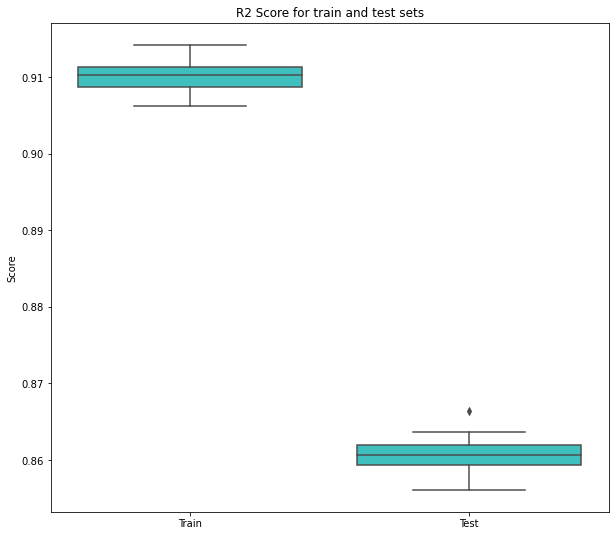

In [9]:
cv_scores = pd.DataFrame(
    {
        "Train": cv_model['train_r2'],
        "Test": cv_model['test_r2']
    }
)
plt.figure(figsize=(10, 9))
sns.boxplot(data=cv_scores, orient='v', color='cyan', saturation=0.5)
plt.ylabel('Score')
plt.title('R2 Score for train and test sets')
# plt.savefig("r2_score.png", dpi=300)
plt.show()

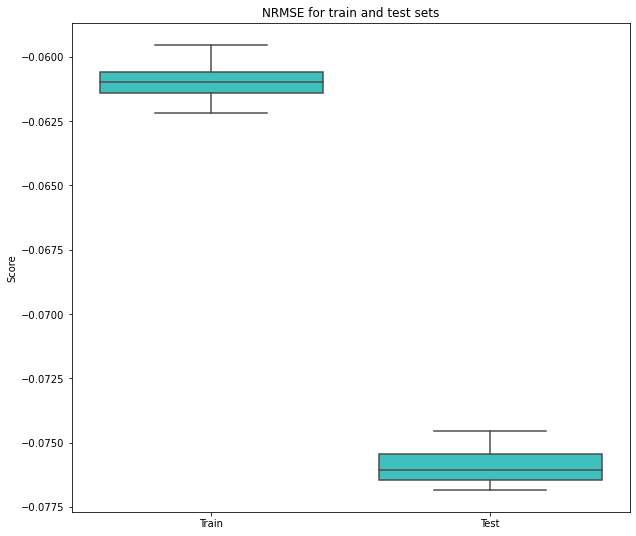

In [10]:
cv_scores = pd.DataFrame(
    {
        "Train": cv_model['train_neg_root_mean_squared_error'],
        "Test": cv_model['test_neg_root_mean_squared_error']
    }
)
plt.figure(figsize=(10, 9))
sns.boxplot(data=cv_scores, orient='v', color='cyan', saturation=0.5)
plt.ylabel('Score')
plt.title('NRMSE for train and test sets')
# plt.savefig("nrmse_score.png", dpi=300)
plt.show()

As you can see, it wasn't lucky, the model learn very well (not perfect) but is enough for our goal: feature importance

## Explanation Model

### SHAP Values

This is a unified framework for explaining model predictions. This tool is motivated by the idea that model interpretability is as important as model accuracy, since some modern models act as black boxes due to its complexity.

There are three main points that make everyone loves this approach:

1. Interpreting a prediction model is a model itself. In particular, it beloong to the class of additive feature attribution methods.
2. Game theory results guaranteeing a unique solution.
3. This new method is better aligned with human intuition

In [7]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [12]:
import h5py
with h5py.File("shap_values.h5", 'r') as hf:
    shap_values = hf['shap_values'][:]

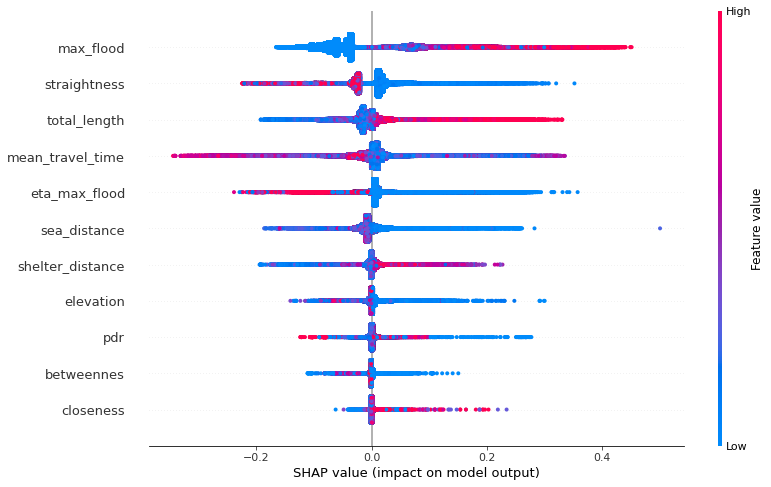

In [13]:
shap.summary_plot(shap_values, X, show=False, plot_size=(12, 8))
# plt.savefig("shap_summary.png")
plt.show()

The last visualization gives us a lot of insights related to the model and how each feature contribute to the prediction.

_Keep it simple_.

* Each point correspond to a cell's data field value, then each row of this plot shows us around 530,000 points.
* The color represents the (standarized) value of the each observation.
* Their horizontal place corresponds to the impact on the model, since we are predicting the tsunami death ratio then if a point has been plotted on the right side that means it increases the death ratio prediction.

For example, the maximum flood is one of the most important feature of the model, since a lot of the observations have a large absolute SHAP value. In order to interprete this notice the righ side points are mostly red, so that means that cells with a large maximum flood value incresing the death ratio prediction.

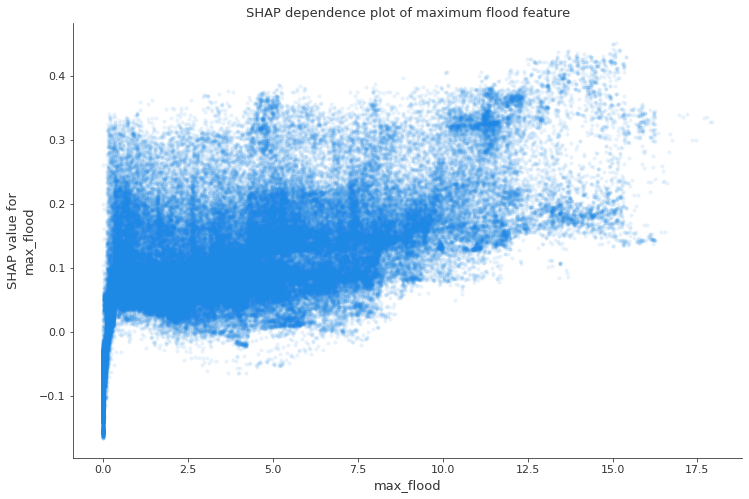

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
shap.dependence_plot(
    ind="max_flood",
    shap_values=shap_values,
    features=X,
    interaction_index=None,
    alpha=0.1,
    title="SHAP dependence plot of maximum flood feature",
    ax=ax
)
fig.tight_layout()
# fig.savefig("shap_dependence_maximum_flood.png", dpi=300)
fig.show()

These are the same values but only for the maximum flood feature, as you can see, while bigger is the maximum flood, bigger is the contribution to the prediction, but very small values even could contribuite in a negative way.

I hope you enjoyed this blog post, I prefered to make the things simple. This is only a little introduction and I wanted to show how is working in a multi-disciplinary team.

See you next time!